In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [3]:
# Activity/Scenario metadata as described in data/MobiActV2/README.txt
ACTIVITY_DESCRIPTIONS = {
    "STD": "Standing",
    "WAL": "Walking",
    "JOG": "Jogging",
    "JUM": "Jumping",
    "STU": "Stairs up",
    "STN": "Stairs down",
    "SCH": "Stand to sit",
    "SIT": "Sitting",
    "CHU": "Sit to stand",
    "CSI": "Car step in",
    "CSO": "Car step out",
}

SCENARIO_DESCRIPTIONS = {
    "SLH": "Leaving home",
    "SBW": "Being at work",
    "SLW": "Leaving work",
    "SBE": "Exercising",
    "SRH": "Returning home",
}

## Activity and scenario info
Find the number of subjects and total frames for each activity/scenario

In [4]:
# List of all files in the MobiActV2 dataset
files = np.array(os.listdir("data/MobiActV2/frames"))

In [5]:
def get_dataset_df(files, target_labels):
    """ Extract activity/scenario labels, subject ids and frame numbers for each data file. """

    target_files = pd.DataFrame(
        [f for f in files if f.split("_")[0] in target_labels], columns=["filename"]
    )
    target_files["label"] = target_files["filename"].apply(lambda x: x.split("_")[0])
    target_files["subject"] = target_files["filename"].apply(lambda x: x.split("_")[1])
    target_files["frame"] = target_files["filename"].apply(
        lambda x: x.split("_")[-1][:-4]
    )

    return target_files

In [6]:
# Get label/subject/frame info for all activity and scenario files
activity_files = get_dataset_df(files, ACTIVITY_DESCRIPTIONS)
scenario_files = get_dataset_df(files, SCENARIO_DESCRIPTIONS)

### Activities

In [7]:
np.unique(list(map(lambda x: x.split("_")[1], files)))

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
       '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59',
       '6', '60', '61', '62', '63', '64', '65', '66', '67', '7', '8', '9'],
      dtype='<U2')

In [8]:
activity_stats = pd.DataFrame()
for activity in ACTIVITY_DESCRIPTIONS:
    # Query only the activity specific files
    df = activity_files.query(f"label == '{activity}'")

    # Activity info
    activity_series = pd.Series()
    activity_series["activity"] = activity
    activity_series["n_subjects"] = df.subject.nunique()
    activity_series["n_frames"] = len(df)

    activity_stats = activity_stats.append(activity_series, ignore_index=True)
activity_stats

,activity,n_frames,n_subjects
0,STD,6000.0,60.0
1,WAL,6100.0,61.0
2,JOG,1830.0,61.0
3,JUM,1830.0,61.0
4,STU,1456.0,61.0
5,STN,1460.0,61.0
6,SCH,730.0,61.0
7,SIT,380.0,19.0
8,CHU,228.0,19.0
9,CSI,716.0,60.0


In [9]:
activity_stats.n_frames * 3 / 60

0     300.0
1     305.0
2      91.5
3      91.5
4      72.8
5      73.0
6      36.5
7      19.0
8      11.4
9      35.8
10     36.0
Name: n_frames, dtype: float64

### Scenarios

In [10]:
scenario_stats = pd.DataFrame()
for scenario in SCENARIO_DESCRIPTIONS:
    # Query only the scenario specific files
    df = scenario_files.query(f"label == '{scenario}'")

    # Scenario info
    scenario_series = pd.Series()
    scenario_series["activity"] = scenario
    scenario_series["n_subjects"] = df.subject.nunique()
    scenario_series["n_frames"] = len(df)

    scenario_stats = scenario_stats.append(scenario_series, ignore_index=True)
scenario_stats

,activity,n_frames,n_subjects
0,SLH,760.0,19.0
1,SBW,1139.0,19.0
2,SLW,1139.0,19.0
3,SBE,760.0,19.0
4,SRH,949.0,19.0


## Data ranges
Make sure the data ranges are valid. According to the Android API the sensors should have the following ranges:

- Accelerometer: [-20, 20] ($m/s^2$)
- Gyroscope: [-10, 10] ($rad/s$)
- Orientation:
    - Azimuth: [0, 360] ($degrees$)
    - Pitch: [-180, 180] ($degrees$)
    - Roll: [-90, 90] ($degrees$)

### Activities
Sensor minimum and maximum values across all activity frames

In [11]:
min_values = {}
max_values = {}
for file in activity_files.filename:
    # Load data
    df = pd.read_csv(os.path.join("data/MobiActV2/frames", file))

    # Data ranges
    min_values[file] = (
        df[
            [
                "acc_x",
                "acc_y",
                "acc_z",
                "gyro_x",
                "gyro_y",
                "gyro_z",
                "azimuth",
                "pitch",
                "roll",
            ]
        ]
        .min()
        .to_dict()
    )
    max_values[file] = (
        df[
            [
                "acc_x",
                "acc_y",
                "acc_z",
                "gyro_x",
                "gyro_y",
                "gyro_z",
                "azimuth",
                "pitch",
                "roll",
            ]
        ]
        .max()
        .to_dict()
    )

In [12]:
pd.DataFrame(min_values).T.min()

acc_x      -19.520784
acc_y      -19.558117
acc_z      -18.676104
gyro_x      -9.990934
gyro_y     -10.003592
gyro_z      -9.492748
azimuth      0.000000
pitch     -179.999770
roll       -89.340800
dtype: float64

In [13]:
pd.DataFrame(max_values).T.max()

acc_x       19.534640
acc_y       19.585407
acc_z       19.057516
gyro_x       9.899072
gyro_y      10.006609
gyro_z       8.894887
azimuth    359.997560
pitch      179.999190
roll        89.749520
dtype: float64

### Scenarios
Sensor minimum and maximum values across all scenario frames

In [14]:
min_values = {}
max_values = {}
for file in scenario_files.filename:
    # Load data
    df = pd.read_csv(os.path.join("data/MobiActV2/frames", file))

    # Data ranges
    min_values[file] = (
        df[
            [
                "acc_x",
                "acc_y",
                "acc_z",
                "gyro_x",
                "gyro_y",
                "gyro_z",
                "azimuth",
                "pitch",
                "roll",
            ]
        ]
        .min()
        .to_dict()
    )
    max_values[file] = (
        df[
            [
                "acc_x",
                "acc_y",
                "acc_z",
                "gyro_x",
                "gyro_y",
                "gyro_z",
                "azimuth",
                "pitch",
                "roll",
            ]
        ]
        .max()
        .to_dict()
    )

In [15]:
pd.DataFrame(min_values).T.min()

acc_x      -19.512802
acc_y      -19.526285
acc_z      -18.766493
gyro_x      -9.973900
gyro_y      -9.874219
gyro_z      -9.898755
azimuth      0.008716
pitch     -179.849670
roll       -87.681725
dtype: float64

In [16]:
pd.DataFrame(max_values).T.max()

acc_x       19.532300
acc_y       19.535648
acc_z       18.455988
gyro_x       9.925303
gyro_y      10.006644
gyro_z       9.216776
azimuth    359.989260
pitch      179.912690
roll        89.687860
dtype: float64

## Plot random examples for each activity
Each activity frame is labeled according to the "main" activity in the source data file, meaning that it's possible that a frame contains different/additional activities than it's title in the below plots.
For example, the activity files for SCH (standing-to-sitting transition) contains three activities: standing, standing-to-sitting transition, and sitting.

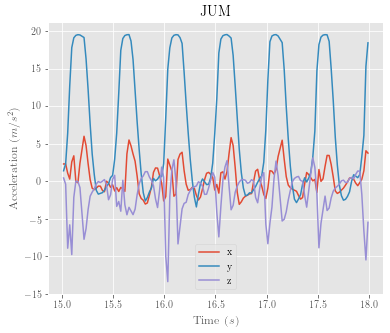

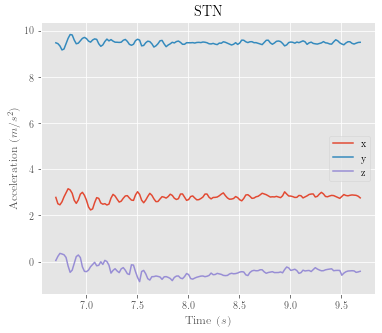

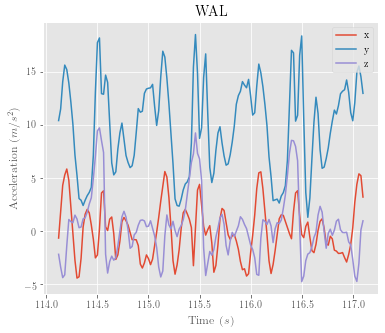

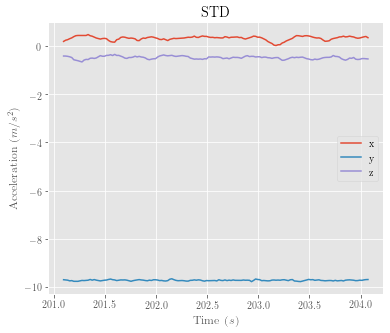

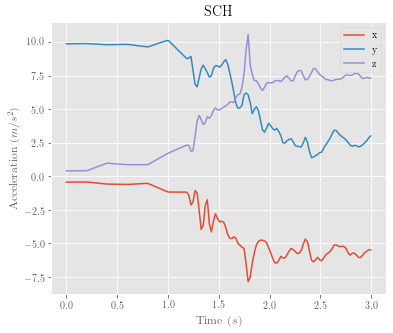

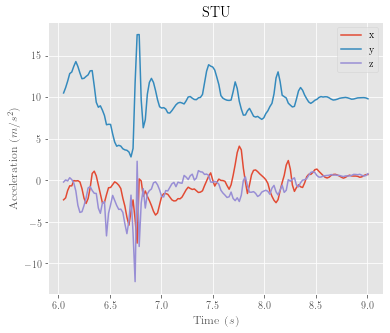

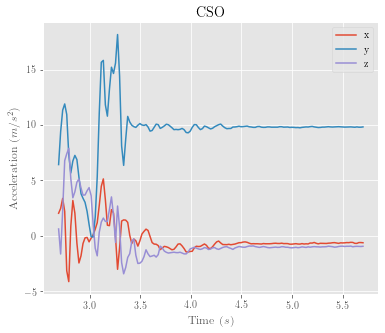

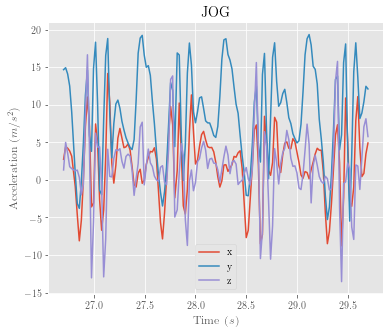

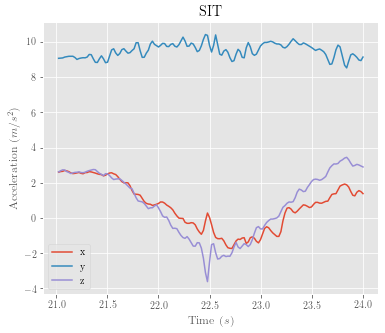

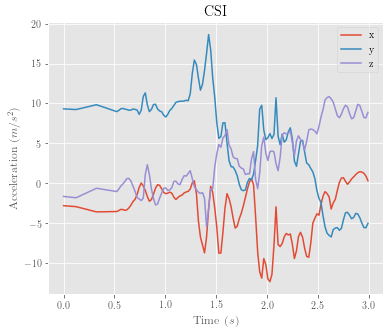

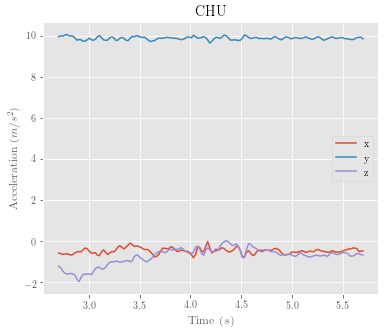

In [17]:
# Select sensors to display in plot
sensors = ["acc_x", "acc_y", "acc_z"]

for activity in activity_files.label.unique():
    filename = activity_files.query(f"label == '{activity}'").sample()
    df = pd.read_csv(os.path.join("data/MobiActV2/frames", filename.filename.values[0]))
    plt.figure(figsize=(6, 5))
    plt.title(activity)
    plt.plot(df.rel_time, df[sensors])
    plt.xlabel("Time $(s)$")
    plt.ylabel("Acceleration $(m/s^2)$")
    plt.legend(["x", "y", "z"])
    plt.show()

## Class weights

Class weights are determined by the number of frames containing each activity

In [18]:
# Compute inverse class weights and normalize
inverse_weights = 1 / activity_stats.n_frames
inverse_weights = inverse_weights / inverse_weights.sum()

In [19]:
inverse_weights

0     0.011932
1     0.011736
2     0.039121
3     0.039121
4     0.049170
5     0.049035
6     0.098070
7     0.188398
8     0.313997
9     0.099988
10    0.099432
Name: n_frames, dtype: float64

In [20]:
# Save class weights
np.save("data/MobiActV2/class_weights.npy", inverse_weights.values)